In [1]:
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras import layers , activations , models , preprocessing
from tensorflow.keras import preprocessing , utils
import pandas as pd
import re
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
data = pd.read_json("../input/frames-chatbot-dataset/frames.json")

In [3]:
d = data['turns']

In [4]:
data['chat'] = data['turns'].apply(lambda x: [item['text'] for item in x])
print(data['chat'].iloc[0])

["I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700.", 'Hi...I checked a few options for you, and unfortunately, we do not currently have any trips that meet this criteria.  Would you like to book an alternate travel option?', 'Yes, how about going to Neverland from Caprica on August 13, 2016 for 5 adults. For this trip, my budget would be 1900.', 'I checked the availability for this date and there were no trips available.  Would you like to select some alternate dates?', 'I have no flexibility for dates... but I can leave from Atlantis rather than Caprica. How about that?', 'I checked the availability for that date and there were no trips available.  Would you like to select some alternate dates?', "I suppose I'll speak with my husband to see if we can choose other dates, and then I'll come back to you.Thanks for your help"]


In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [6]:
data['user'] = data['chat'].apply(lambda x: x[0::2])
data['bot'] = data['chat'].apply(lambda x: x[1::2])

In [7]:
data['user']

0       [I'd like to book a trip to Atlantis from Capr...
1       [Hello, I am looking to book a vacation from G...
2       [Hello there i am looking to go on a vacation ...
3       [Hi I'd like to go to Caprica from Busan, betw...
4       [Hello, I am looking to book a trip for 2 adul...
                              ...                        
1364    [Hi I've got 9 days free and I'm looking for a...
1365    [I need to get to Fortaleza on September 8th o...
1366    [We're finally going on vacation isn't that am...
1367    [Hi there, I'm looking for a place to get away...
1368    [I need to book a trip for the whole family fr...
Name: user, Length: 1369, dtype: object

In [8]:
question = []
answer = []

In [9]:
for i in range(len(data['user'])):
    for j in range(len(data['user'][i])):
        question.append(preprocess_sentence(data['user'][i][j]))

In [10]:
for i in range(len(data['bot'])):
    for j in range(len(data['bot'][i])):
        answer.append(preprocess_sentence(data['bot'][i][j]))

In [11]:
print(question[0])
print(answer[0])

i d like to book a trip to atlantis from caprica on saturday , august , for adults . i have a tight budget of .
hi . . . i checked a few options for you , and unfortunately , we do not currently have any trips that meet this criteria . would you like to book an alternate travel option ?


In [12]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    question + answer, target_vocab_size=2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [13]:
print('Sample question: {}'.format(question[0]))

Sample question: i d like to book a trip to atlantis from caprica on saturday , august , for adults . i have a tight budget of .


In [14]:
print('Tokenized sample question: {}'.format(tokenizer.encode(question[0])))

Tokenized sample question: [2, 140, 30, 3, 39, 8, 56, 3, 1130, 15, 1488, 27, 844, 5, 179, 5, 11, 250, 1, 2, 12, 8, 1047, 94, 114, 10]


In [15]:
# Maximum sentence length
MAX_LENGTH = 40


# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = (), ()
    #c = 0
    for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # check tokenized sentence max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
#             if type(tokenized_inputs) == type(_):
#                 tokenized_inputs.tolist()
            tokenized_inputs = list(tokenized_inputs)
            tokenized_inputs.append(sentence1)
#             if type(tokenized_outputs) != type(_):
#                 tokenized_outputs.tolist()
            tokenized_outputs = list(tokenized_outputs)
            tokenized_outputs.append(sentence2)
  
  # pad tokenized sentence
        tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
            tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
        tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
          tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
        #c += 1
        #print(c)
    
    return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(question, answer)

In [16]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 6202
Number of samples: 8670


In [17]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 40), dec_inputs: (None, 39)}, {outputs: (None, 39)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


In [19]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)

    return output

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [21]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [22]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [23]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [24]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
    # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [25]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

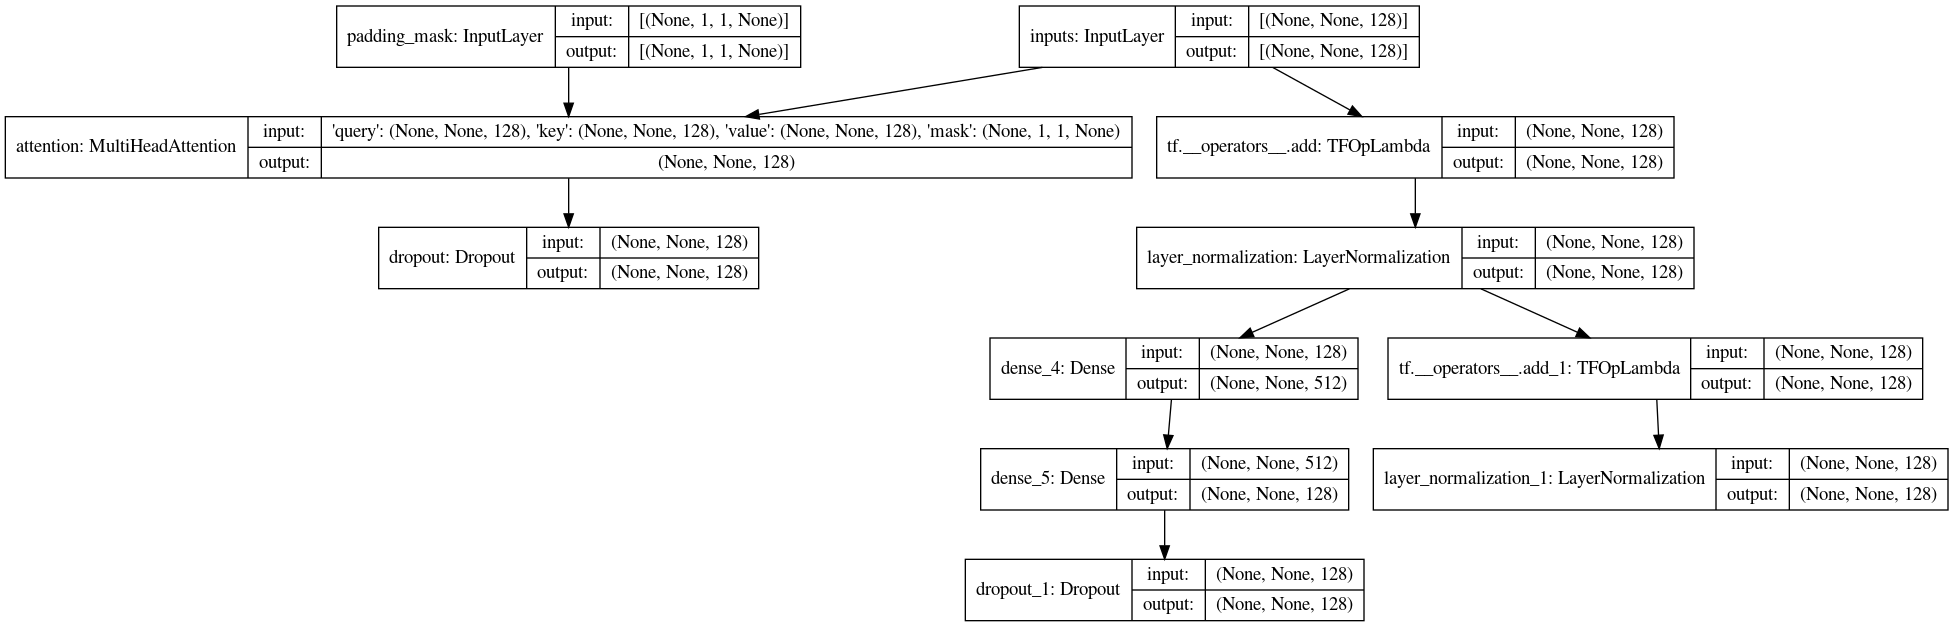

In [26]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

In [27]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

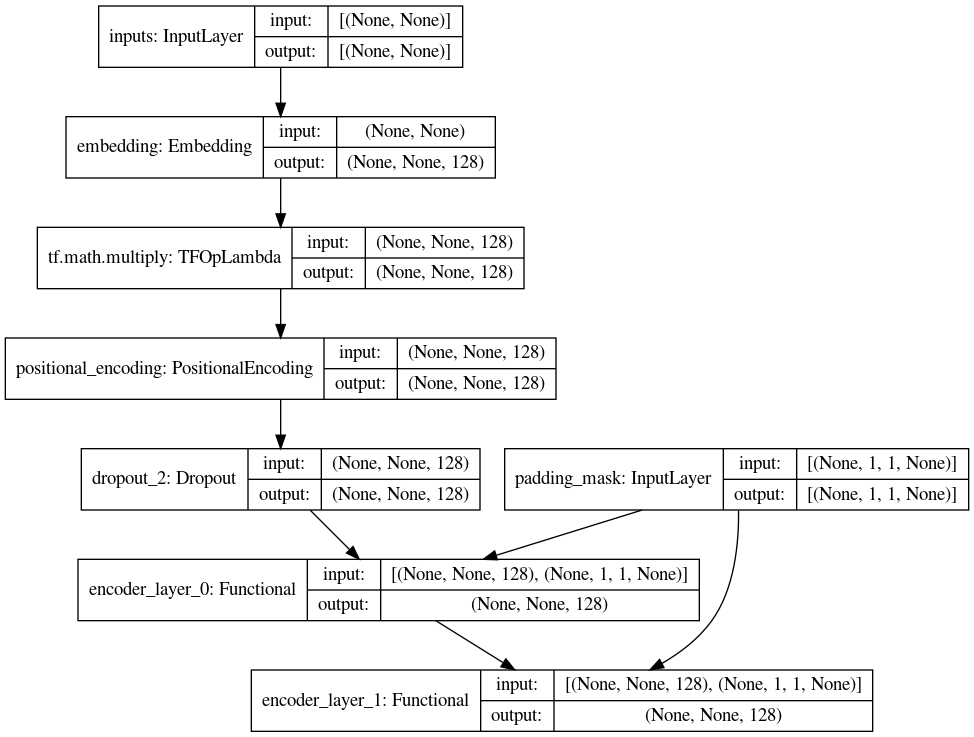

In [28]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

In [29]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

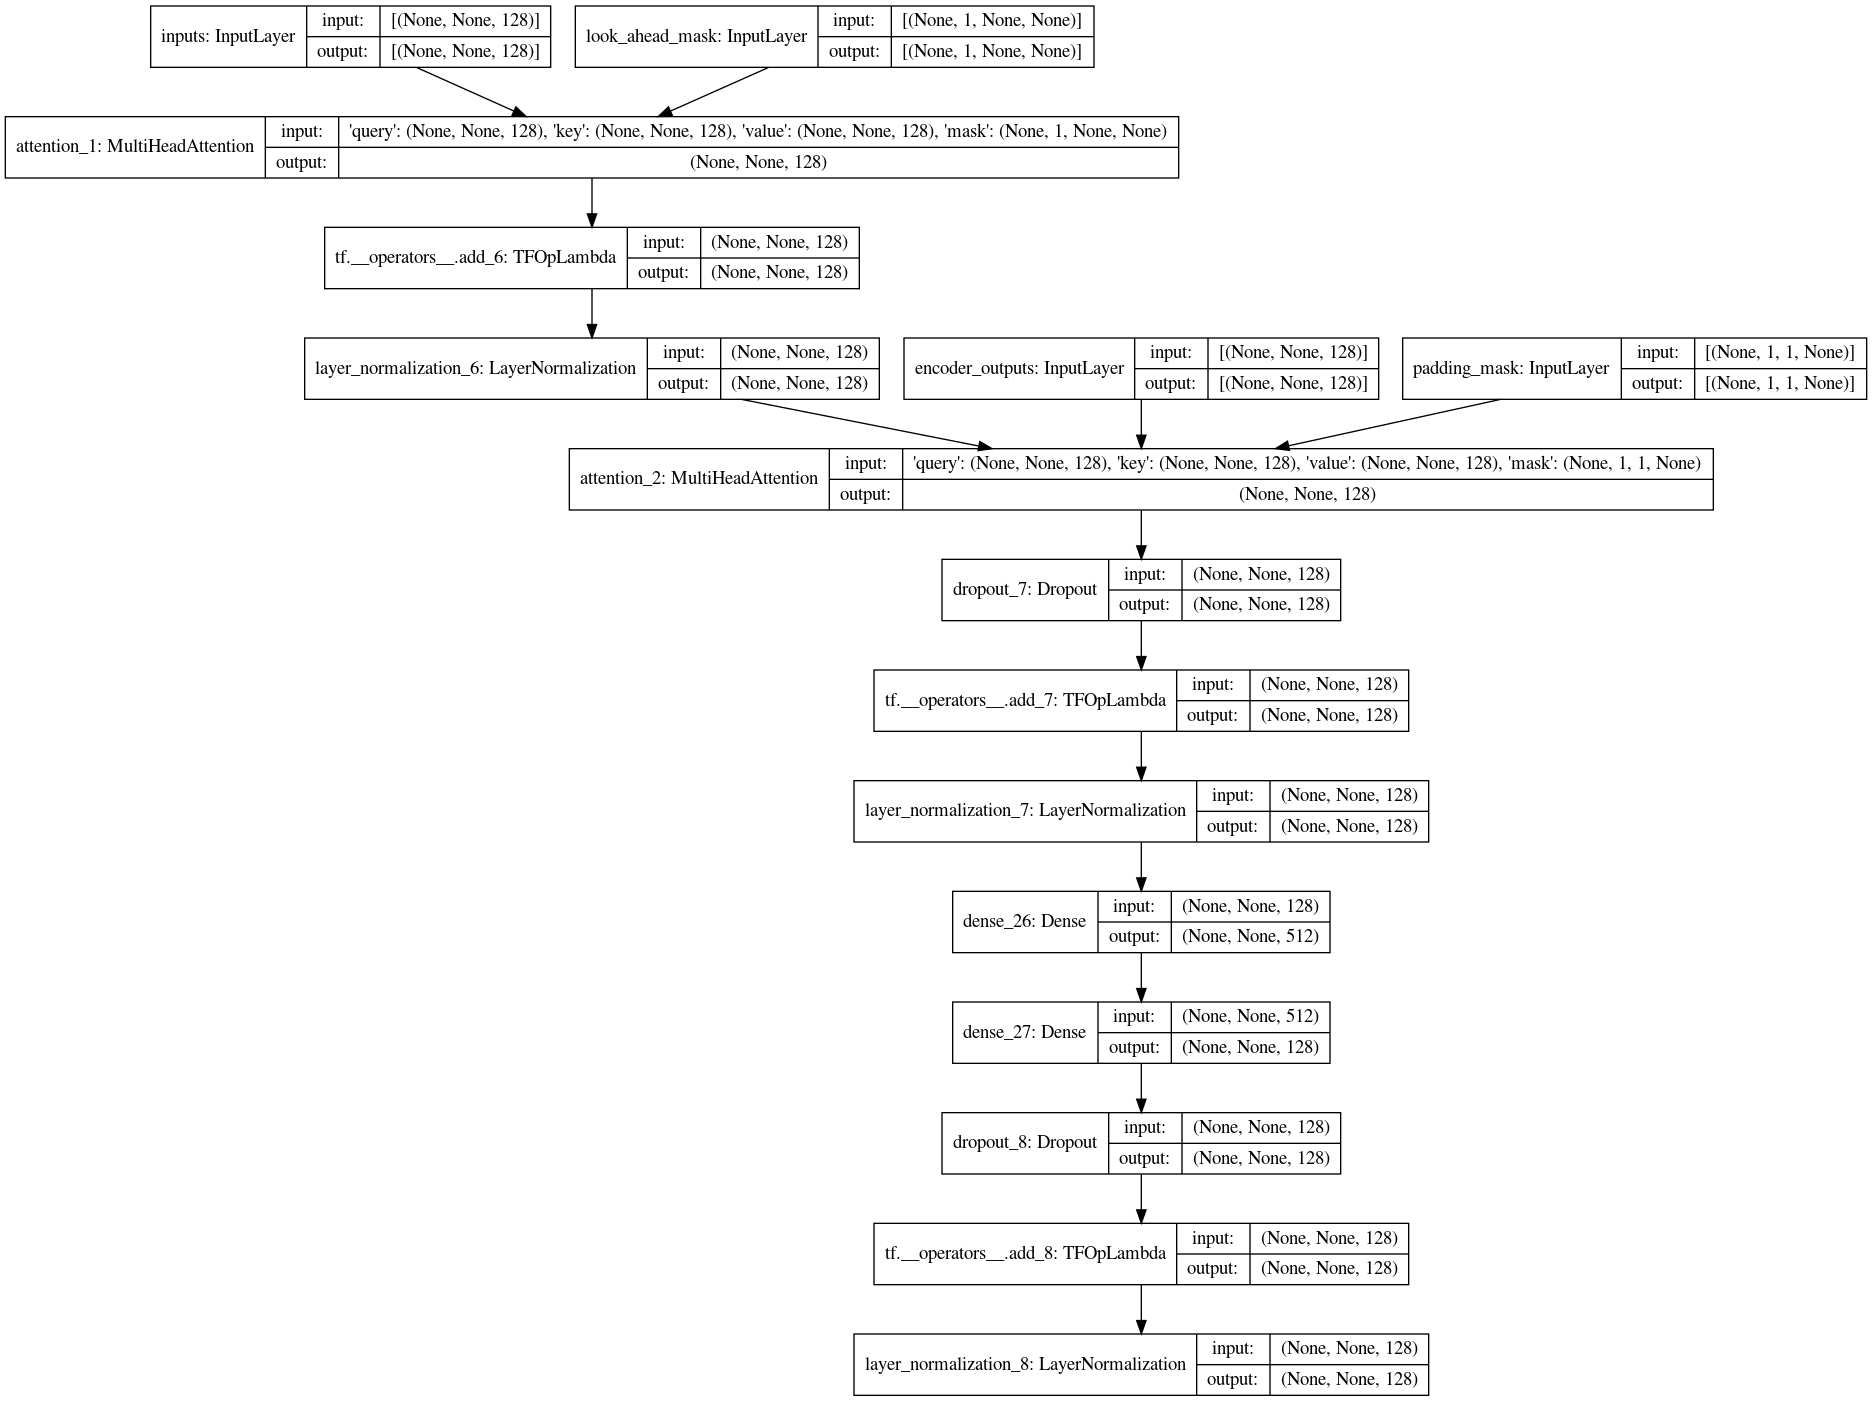

In [30]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

In [31]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

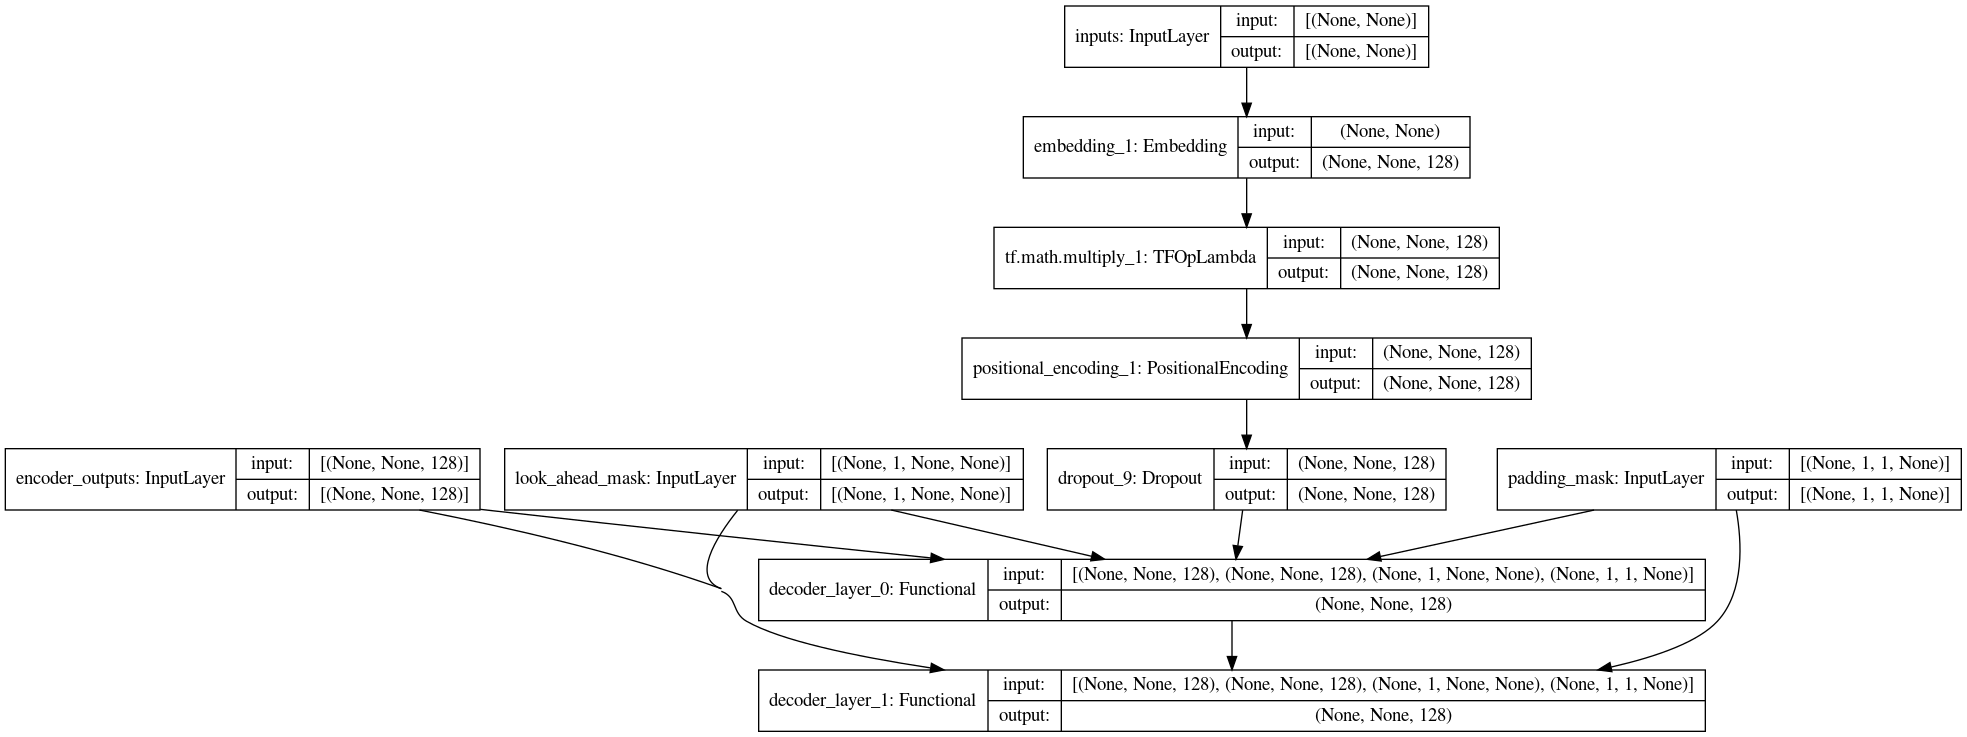

In [32]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

In [33]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

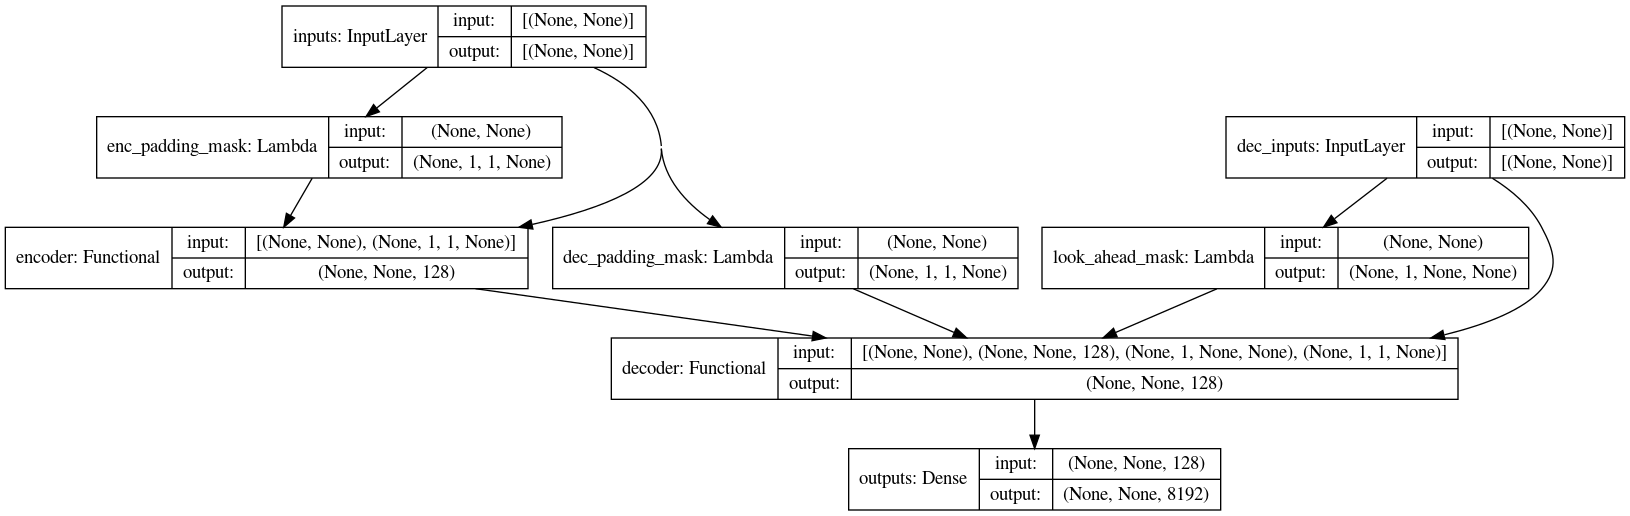

In [34]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

In [35]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [36]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [37]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

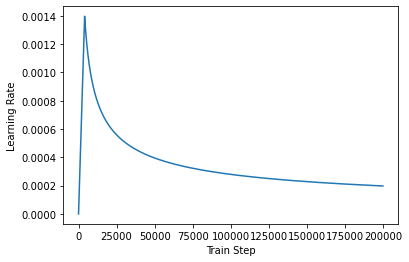

In [38]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [39]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [40]:
EPOCHS = 100

model.fit(dataset, epochs=EPOCHS)

Epoch 1/100
136/136 [==============================] - 17s 73ms/step - loss: 3.2982 - accuracy: 0.0047
Epoch 2/100
136/136 [==============================] - 10s 74ms/step - loss: 2.7727 - accuracy: 0.0258
Epoch 3/100
136/136 [==============================] - 10s 77ms/step - loss: 2.1527 - accuracy: 0.0445
Epoch 4/100
136/136 [==============================] - 10s 74ms/step - loss: 1.7876 - accuracy: 0.0924
Epoch 5/100
136/136 [==============================] - 10s 74ms/step - loss: 1.4863 - accuracy: 0.1185
Epoch 6/100
136/136 [==============================] - 11s 78ms/step - loss: 1.2876 - accuracy: 0.1341
Epoch 7/100
136/136 [==============================] - 10s 74ms/step - loss: 1.1691 - accuracy: 0.1460
Epoch 8/100
136/136 [==============================] - 10s 74ms/step - loss: 1.0757 - accuracy: 0.1553
Epoch 9/100
136/136 [==============================] - 10s 75ms/step - loss: 1.0150 - accuracy: 0.1637
Epoch 10/100
136/136 [==============================] - 10s 76ms/step - l

In [41]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
              break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence):
    prediction = evaluate(sentence)

    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

In [42]:
print(data['user'][2])
print(data['bot'][2])

['Hello there i am looking to go on a vacation with my family to Gotham City, can you help me?', 'Not sure when we want to leave, but we are 12 kids and 5 adults', 'yes i do, it is around $2200', 'We are from Neverland', 'we can depart from Toronto', 'hmm what options would i have out of Toronto?', 'that would be nice', 'No sorry i was planning on getting a tan this vacation. Thanks, is there anywhere else? Thank you\nis there anywhere else?', 'What options do you have available for me?', 'That sounds interesting. how many stars does the hotel have?', 'Ahh...maybe another time']
['when  would you like to travel and how many people will you be?', 'do you have a budget?', 'where will you be travelling from?', 'We have nothing available leaving from Neverland, are you able to depart from another city?', 'Gotham City is not a destination we travel to. Are you interested in any other destinations?', 'Would you be interested in Calgary?', 'I have a departure from Toronto to Calgary  on Augus

In [43]:
output = predict('HELLO THERE I AM IN MILAN AND LOOKING TO TRAVEL TO SANTO DOMINGO ON WEDNESDAY AUGUST 24. SORRY FOR ALL THE YELLING I\'M IN A HELICOPTER')

Input: HELLO THERE I AM IN MILAN AND LOOKING TO TRAVEL TO SANTO DOMINGO ON WEDNESDAY AUGUST 24. SORRY FOR ALL THE YELLING I'M IN A HELICOPTER
Output: not a problem ! where are you leaving from and which dates would you like to leave between ?


In [44]:
# feed the model with its previous output
sentence = 'Hello there i am looking to go on a vacation with my family to Gotham City, can you help me?'
for _ in range(5):
    sentence = predict(sentence)
    print('')

Input: Hello there i am looking to go on a vacation with my family to Gotham City, can you help me?
Output: do you have a budget ?

Input: do you have a budget ?
Output: it s a . star hotel that includes free breakfast , parking , and wifi . would you like to book economy or business ?

Input: it s a . star hotel that includes free breakfast , parking , and wifi . would you like to book economy or business ?
Output: travelling alone ?

Input: travelling alone ?
Output: i m not sure i understand . will you be travelling alone ?

Input: i m not sure i understand . will you be travelling alone ?
Output: awesome ! i will book it for you . you will receive a confirmation email with the next five minutes ! have a nice day !

